In [1]:
import torch; torch.manual_seed(0)
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions
from torch.utils.data import Dataset
import torchvision
import numpy as np
import matplotlib.pyplot as plt; plt.rcParams['figure.dpi'] = 200
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from torch.utils.tensorboard import SummaryWriter
from random import shuffle
import itertools
import io
import wandb
%load_ext tensorboard

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
class VariationalEncoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalEncoder, self).__init__()
        init_channels = 16
        self.conv1 = nn.Conv2d(1, init_channels, kernel_size=3, padding=1, stride=2)
        self.skip_conv1 = nn.Conv2d(1, init_channels, kernel_size=3, padding=1, stride=2)
        self.conv2 =  nn.Conv2d(init_channels, init_channels*2, kernel_size=3, padding=1, stride=2)
        self.skip_conv2 =  nn.Conv2d(init_channels, init_channels*2, kernel_size=3, padding=1, stride=2)
        self.conv3 =  nn.Conv2d(init_channels*2, init_channels*4, kernel_size=3, padding=1, stride=2)
        self.skip_conv3 =  nn.Conv2d(init_channels*2, init_channels*4, kernel_size=3, padding=1, stride=2)
        self.activation = nn.ReLU()

        self.linear_mu = nn.Linear(init_channels*4*4*4,latent_dims)
        self.linear_sigma = nn.Linear(init_channels*4*4*4,latent_dims)
        
        self.N = torch.distributions.Normal(0, 1)
        self.N.loc = self.N.loc.cuda() # hack to get sampling on the GPU
        self.N.scale = self.N.scale.cuda()
        self.kl = 0

    def forward(self, x):
        x = self.activation(self.conv1(x))+self.skip_conv1(x)
        x = self.activation(self.conv2(x))+self.skip_conv2(x)
        x = self.activation(self.conv3(x))+self.skip_conv3(x)
        x = torch.flatten(x, start_dim=1)
        mu =  self.linear_mu(x)
        logvar = self.linear_sigma(x)
        self.kl = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp().pow(2))
        sigma = torch.exp(logvar/2)
        return mu, sigma

In [4]:
class Decoder(nn.Module):
    def __init__(self, latent_dims):
        super(Decoder, self).__init__()
        init_channels = 16
        self.linear = nn.Linear(latent_dims, init_channels*4*4*4)
        self.convT1 = nn.ConvTranspose2d(init_channels*4,init_channels*2,kernel_size=2,stride=2)
        self.skip_convT1 = nn.ConvTranspose2d(init_channels*4,init_channels*2,kernel_size=2,stride=2)
        self.convT2 = nn.ConvTranspose2d(init_channels*2,init_channels,kernel_size=2,stride=2)
        self.skip_convT2 = nn.ConvTranspose2d(init_channels*2,init_channels,kernel_size=2,stride=2)
        self.convT3 = nn.ConvTranspose2d(init_channels,1,kernel_size=2,stride=2,padding=2)
        self.skip_convT3 = nn.ConvTranspose2d(init_channels,1,kernel_size=2,stride=2,padding=2)
        self.activation = nn.ReLU()

    def forward(self, z):
        init_channels = 16
        z = self.activation(self.linear(z))
        z = z.reshape((-1, init_channels*4, 4, 4))
        z = self.activation(self.convT1(z))+self.skip_convT1(z)
        z = self.activation(self.convT2(z))+self.skip_convT2(z)
        z = self.activation(self.convT3(z))+self.skip_convT3(z)
        return z

    def sample():
        return None

In [5]:
class LogisticRegression(nn.Module):
    def __init__(self, latent_dims, classes):
        super(LogisticRegression, self).__init__()
        self.linear = torch.nn.Linear(latent_dims, classes)
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x):
        x=torch.flatten(x,start_dim=1)
        return self.softmax(self.linear(x))

In [6]:
class VAEClassifer(nn.Module):
    def __init__(self, latent_dims,classes):
        super(VAEClassifer, self).__init__()
        self.encoder = VariationalEncoder(latent_dims)
        self.decoder = Decoder(latent_dims)
        self.classifier = LogisticRegression(latent_dims,classes)

    def forward(self, x):
        mu,sigma = self.encoder(x)
        z = mu + sigma*self.encoder.N.sample(mu.shape)
        #x_hat = VAE.decoder(z)
        #y_pred = self.classifier(z)
        return self.decoder(z), self.classifier(z)

In [7]:
batch_size = 50
valid_batch_size = 6000
def log_confusion_matrix(cm, writer, epoch):
    class_names = list(range(10))
    #plotting code obtained from https://towardsdatascience.com/exploring-confusion-matrix-evolution-on-tensorboard-e66b39f4ac12
    figure = plt.figure(figsize=(8, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion matrix")
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)
    
    # Normalize the confusion matrix.
    cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)
    
    # Use white text if squares are dark; otherwise black.
    threshold = cm.max() / 2.
    
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        color = "white" if cm[i, j] > threshold else "black"
        plt.text(j, i, cm[i, j], horizontalalignment="center", color=color)
        
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    writer.add_figure('Confusion Matrix', figure, epoch)
    plt.close(figure)

def log_label_dist(preds,writer,epoch):
    figure = plt.figure(figsize=(8, 8))
    plt.bar(list(range(10)),preds)
    writer.add_figure('Labels Histogram', figure, epoch)
    plt.close(figure)

def sharpen(dist, T):
    dist = dist**T
    return dist/torch.sum(dist,dim=1).reshape((-1,1))

def train(VAE, unlabelled_train_data, labelled_train_data, valid_data, epochs=20):
    opt = torch.optim.Adam(VAE.parameters(), weight_decay=1e-2)
    logdir = "./runs/"
    writer = SummaryWriter(logdir)
    pred_loss_func = nn.CrossEntropyLoss()
    highest_accuracy = 0
    for epoch in tqdm(range(epochs)):
        avg_loss = []
        avg_loss_vae = []
        avg_loss_classifer = []
        avg_label_consistency = []
        avg_loss_consistency = []
        avg_hist = np.array([0.0]*10)
        accuracy = 0
        num_data = 0
        for unlabelled, labelled in zip(unlabelled_train_data, labelled_train_data):
            unlabelled_x, _ = unlabelled
            labelled_x, y = labelled
            unlabelled_x = unlabelled_x.to(device)
            labelled_x = labelled_x.to(device)
            y = y.to(device)
            opt.zero_grad()
            
            x_hat, y_pred = VAE(unlabelled_x)
            x_hat_hat, y_hat_pred = VAE(x_hat)
            loss_vae = (((unlabelled_x - x_hat_hat)**2).sum() + ((unlabelled_x - x_hat)**2).sum() + VAE.encoder.kl)/(len(unlabelled_x)+len(labelled_x))
            consistency_loss = 20*pred_loss_func(y_hat_pred,y_pred)
            histogram = torch.sum(y_hat_pred,dim=0)
            
            x_hat, y_pred = VAE(labelled_x)
            x_hat_hat, y_hat_pred = VAE(x_hat)
            loss_vae += (((labelled_x - x_hat_hat)**2).sum() + ((labelled_x - x_hat)**2).sum() + VAE.encoder.kl)/(len(unlabelled_x)+len(labelled_x))
            consistency_loss += 20*pred_loss_func(y_hat_pred,y_pred)
            histogram += torch.sum(y_hat_pred,dim=0)
            loss_classifer = 100*(pred_loss_func(y_hat_pred,y))

            avg_hist += histogram.cpu().detach().numpy()
            histogram = histogram/torch.sum(histogram)
            aggregate_label_consistency = 3200*pred_loss_func(histogram, torch.tensor([.1]*10).to(device))
            loss = loss_vae+loss_classifer+consistency_loss+aggregate_label_consistency
            
            loss.backward()
            opt.step()
            avg_loss.append(loss)
            avg_loss_vae.append(loss_vae)
            avg_loss_classifer.append(loss_classifer)
            avg_label_consistency.append(aggregate_label_consistency)
            avg_loss_consistency.append(consistency_loss)
            accuracy += sum(torch.argmax(y_hat_pred, dim=1) == y)
            num_data += len(y)
        avg_vae = sum(avg_loss_vae)/len(avg_loss_vae)
        avg_classifier = sum(avg_loss_classifer)/(len(avg_loss_classifer))
        avg_label_consistency = sum(avg_label_consistency)/(len(avg_label_consistency))
        avg_consistency = sum(avg_loss_consistency)/(len(avg_loss_consistency))
        writer.add_scalar('Loss/train', avg_vae+avg_classifier+avg_label_consistency+avg_consistency, epoch)
        writer.add_scalar('Loss_VAE/train', avg_vae, epoch)
        writer.add_scalar('Loss_Classifer/train', avg_classifier, epoch)
        writer.add_scalar('Loss_Consistency/train', avg_consistency, epoch)
        writer.add_scalar('Agggregate_Label_consistency/train', aggregate_label_consistency, epoch)
        writer.add_scalar('Accuracy/train',accuracy/num_data, epoch)
        log_label_dist(avg_hist/sum(avg_hist), writer, epoch)
        highest_accuracy = max(highest_accuracy, validate(VAE, valid_data, writer, epoch, highest_accuracy))
    return VAE 

def validate(VAE, data, writer=None, epoch=None, highest_accuracy=None):
    avg_loss = []
    avg_loss_vae = []
    avg_loss_classifer = []
    accuracy = 0
    num_data = 0
    cm = np.zeros((10,10))
    pred_loss_func = nn.CrossEntropyLoss()
    for x, y in data:
        x = x.to(device) # GPU
        y = y.to(device)
        x_hat, y_pred = VAE(x)
        x_hat_hat, y_hat_pred = VAE(x_hat)
        loss_vae = (((x - x_hat)**2).sum() + ((x - x_hat_hat)**2).sum() + VAE.encoder.kl)/batch_size
        loss_classifer = 50*pred_loss_func(y_hat_pred, y) + ((y_pred-y_hat_pred)**2).sum()
        avg_loss.append(loss_vae+loss_classifer)
        avg_loss_vae.append(loss_vae)
        avg_loss_classifer.append(loss_classifer)
        accuracy += sum(torch.argmax(y_hat_pred, dim=1) == y)
        num_data += len(y)
        cm += confusion_matrix(y.cpu().detach().numpy(), torch.argmax(y_hat_pred, dim=1).cpu().detach().numpy())
    if writer:
        writer.add_scalar('Loss/valid', sum(avg_loss_vae)/len(avg_loss_vae)+sum(avg_loss_classifer)/(len(avg_loss_classifer)), epoch)
        writer.add_scalar('Loss_VAE/valid', sum(avg_loss_vae)/len(avg_loss_vae), epoch)
        writer.add_scalar('Loss_Classifer/valid', sum(avg_loss_classifer)/(len(avg_loss_classifer)), epoch)
        writer.add_scalar('Accuracy/valid',accuracy/num_data, epoch)
        log_confusion_matrix(cm, writer, epoch)
    if highest_accuracy and accuracy/num_data > highest_accuracy:
            torch.save(VAE.state_dict(), "mnist_model100labels_aggregate_label.sav")
            highest_accuracy = accuracy/num_data
    return accuracy/num_data

In [8]:
def train_log(logreg, train_data, valid_data, epochs=20):
    opt = torch.optim.Adam(logreg.parameters())
    logdir = "./logreg_runs/"
    writer = SummaryWriter(logdir)
    pred_loss_func = nn.CrossEntropyLoss()
    for epoch in tqdm(range(epochs)):
        avg_loss = []
        accuracy = 0
        num_data = 0
        for x, y in train_data:
            x = x.to(device) # GPU
            y = y.to(device)
            opt.zero_grad()
            y_pred = logreg(x)
            loss = pred_loss_func(y_pred, y)
            loss.backward()
            opt.step()
            avg_loss.append(loss)
            accuracy += sum(torch.argmax(y_pred, dim=1) == y)
            num_data += len(y)
        writer.add_scalar('Loss/train', sum(avg_loss)/len(avg_loss), epoch)
        writer.add_scalar('Accuracy/train',accuracy/num_data, epoch)
        validate_log(logreg, valid_data, writer, epoch)
    return VAE

def validate_log(logreg, data, writer, epoch):
    avg_loss = []
    accuracy = 0
    num_data = 0
    pred_loss_func = nn.CrossEntropyLoss()
    for x, y in data:
        x = x.to(device) # GPU
        y = y.to(device)
        y_pred = logreg(x)
        loss = pred_loss_func(y_pred, y)
        avg_loss.append(loss)
        accuracy += sum(torch.argmax(y_pred, dim=1) == y)
        num_data += len(y)
    writer.add_scalar('Loss/valid', sum(avg_loss)/len(avg_loss), epoch)
    writer.add_scalar('Accuracy/valid',accuracy/num_data, epoch)

In [2]:
batch_size = 50
valid_batch_size = 6000

class SimpleDataset(Dataset):
    def __init__(self, x,y):
        self.x = x
        self.y = y

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]
    
    def __len__(self):
        return len(self.y)

data = torchvision.datasets.MNIST('./mnist_data', transform=torchvision.transforms.ToTensor(), download=True, train=True)
images, labels = zip(*data)
train_images, valid_images, train_labels, valid_labels = train_test_split(images, labels, test_size=.1, stratify=labels, random_state=72)
unlabelled_images, labelled_images, unlabelled_labels, labelled_labels = train_test_split(train_images, train_labels, test_size=100/len(train_labels), stratify=train_labels, random_state=54)

labelled_train_data = torch.utils.data.DataLoader(SimpleDataset(labelled_images, labelled_labels),batch_size=batch_size,shuffle=True)
unlabelled_train_data = torch.utils.data.DataLoader(SimpleDataset(unlabelled_images, unlabelled_labels),batch_size=batch_size,shuffle=True)
valid_data = torch.utils.data.DataLoader(SimpleDataset(valid_images, valid_labels),batch_size=valid_batch_size,shuffle=True)

test_data = torch.utils.data.DataLoader(
        torchvision.datasets.MNIST('./mnist_data',
               transform=torchvision.transforms.ToTensor(),
               download=True, train=False),
        batch_size=1000,
        shuffle=True)

In [8]:
from VAE import VAEClassifer
from training import train

latent_dims = 10
VAE = VAEClassifer(latent_dims,classes=10).to(device) # GPU
VAE = train(VAE, unlabelled_train_data, labelled_train_data, valid_data,epochs=20000, loss_weights={"consistency": 40, "classifer": 100, "aggregate": 3200} ,sav_file="mnist_model_100labels10.sav")

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 14186/20000 [3:23:29<1:23:23,  1.16it/s]


KeyboardInterrupt: 

In [ ]:
from VAE import VAEClassifer
from training import train

latent_dims = 10
VAE = VAEClassifer(latent_dims,classes=10).to(device) # GPU
VAE.load_state_dict(torch.load("mnist_model_100labels10modded.sav", weights_only=True))
VAE = train(VAE, unlabelled_train_data, labelled_train_data, valid_data,epochs=20000, loss_weights={"consistency": 150, "classifer": 100, "aggregate": 3200} ,sav_file="mnist_model_100labels10modded2.sav")

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                      | 14266/20000 [9:18:07<682:16:10, 428.35s/it]

In [18]:
print(VAE.decoder.fixed_scale)

Parameter containing:
tensor(-9.8465, device='cuda:0', requires_grad=True)


In [5]:
from VAE import VAEClassifer
from training import validate
latent_dims = 10
VAE = VAEClassifer(latent_dims,classes=10).to(device) # GPU
VAE.load_state_dict(torch.load("mnist_model_100labels9modded.sav", weights_only=True))
print(validate(VAE,test_data))
print(validate(VAE,torch.utils.data.DataLoader(data,batch_size=1000, shuffle=True)))

tensor(0.9441, device='cuda:0')
tensor(0.9463, device='cuda:0')


In [ ]:
VAE = train(VAE, unlabelled_train_data, labelled_train_data, valid_data,epochs=1500)

In [ ]:
logreg = LogisticRegression(32*32*3,10).to(device)
logreg = train_log(logreg, train_data, valid_data,epochs=1000)

In [94]:
def plot_reconstructed(autoencoder, r0=(-5, 10), r1=(-10, 5), n=12):
    w = 32
    img = np.zeros((3,n*w, n*w))
    for i, y in enumerate(np.linspace(*r1, n)):
        for j, x in enumerate(np.linspace(*r0, n)):
            z = torch.rand(50).to('cuda')
            x_hat = autoencoder.decoder(z)
            x_hat = x_hat.reshape(3, 32, 32).to('cpu').detach().numpy()
            img[:,(n-1-i)*w:(n-1-i+1)*w, j*w:(j+1)*w] = x_hat
    plt.imshow(np.moveaxis(img,0,2), extent=[*r0, *r1])


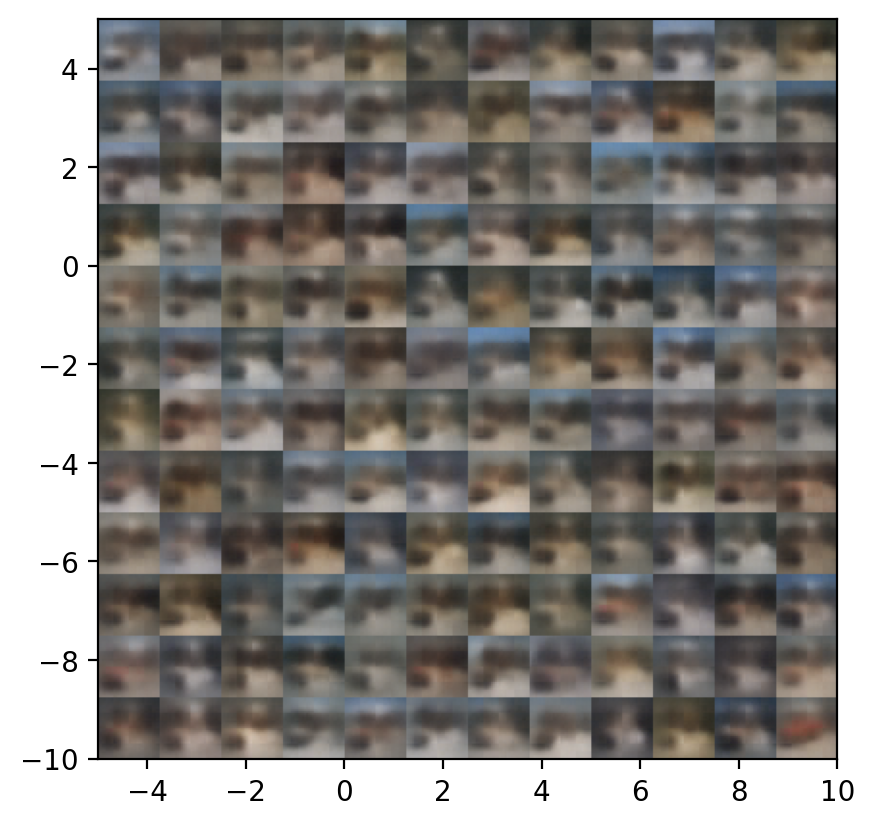

In [95]:
plot_reconstructed(autoencoder,n=12)

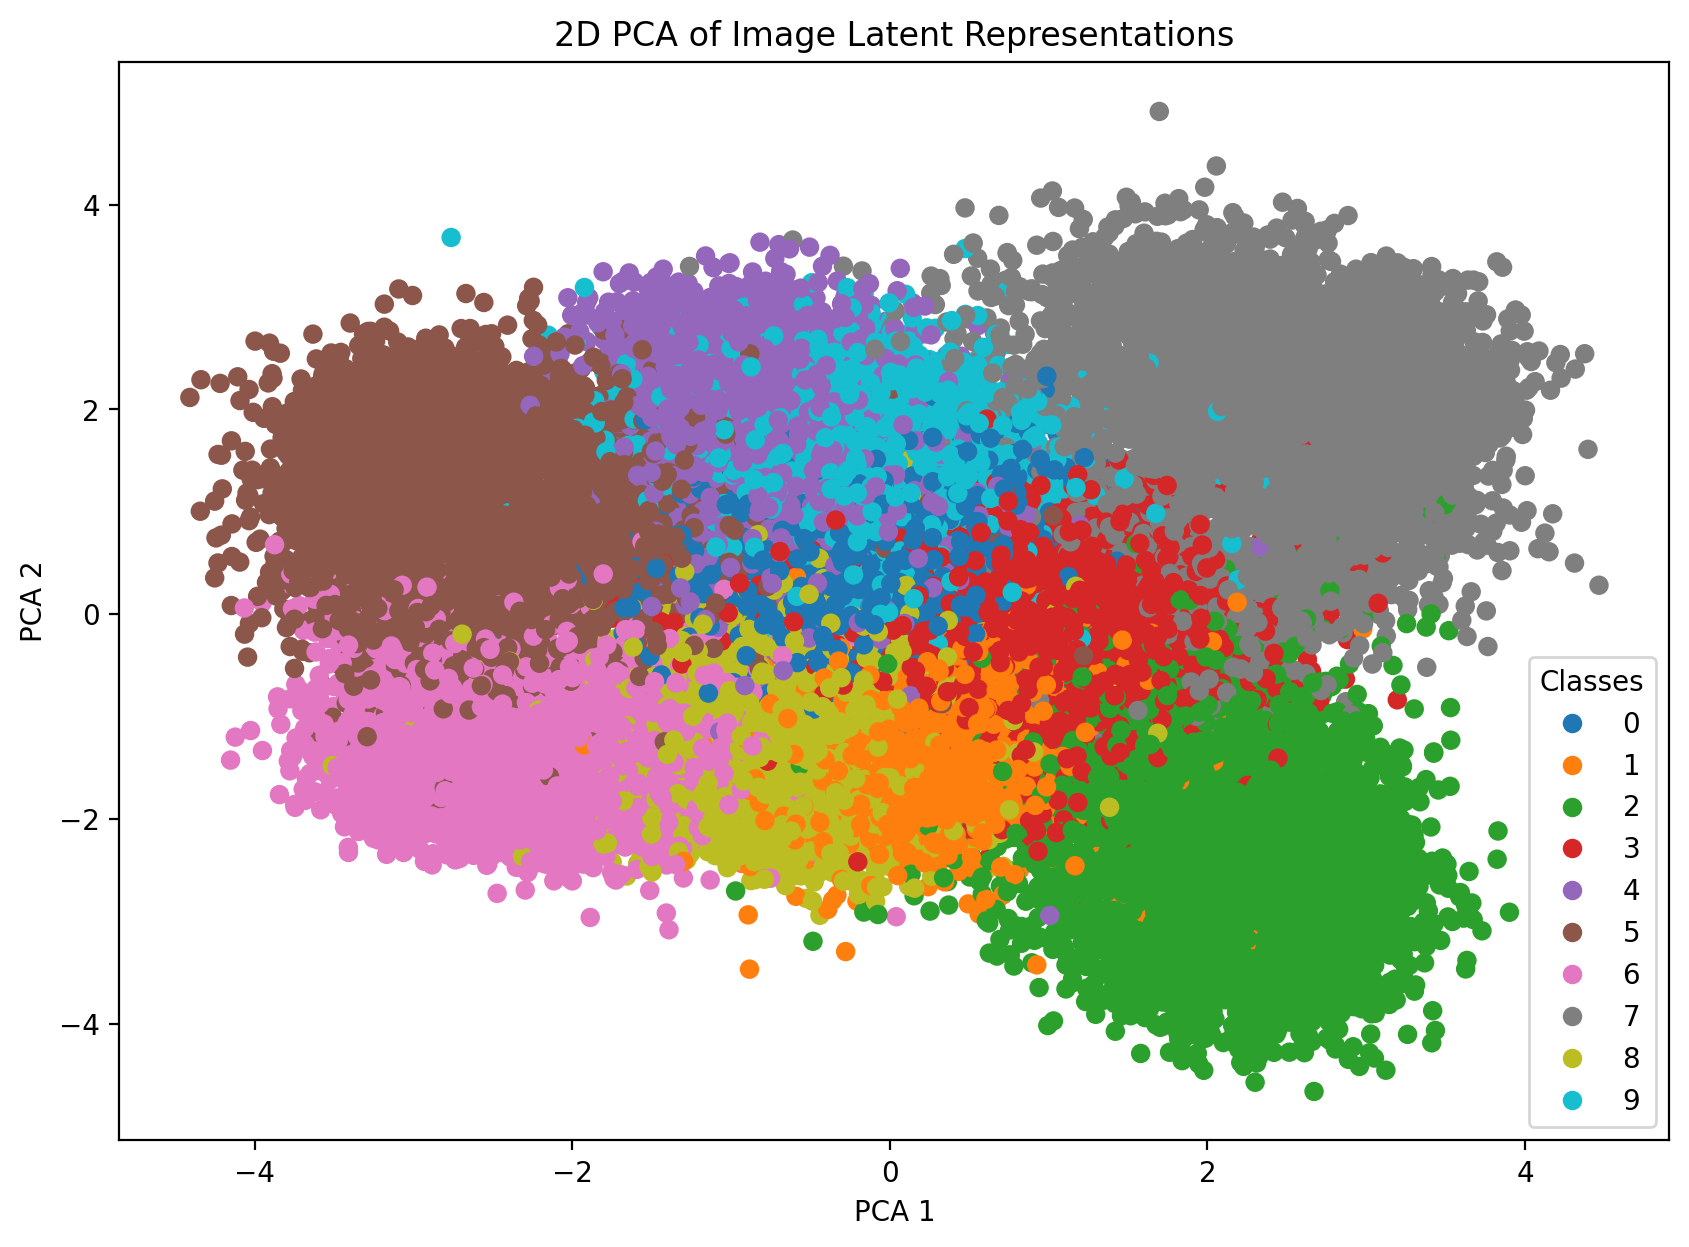

In [97]:
def get_latent(vae, data, num_batches=100, latent_dims=20):
    z_batches = torch.empty((0, latent_dims))
    y_batches = torch.empty((0, ))
    
    # data loader with batch size 128
    for i, (x, y) in enumerate(data):
        # Decode z to distribution parameters
        mu, sigma = vae.encoder(x.to('cuda'))

        z = mu + sigma*vae.encoder.N.sample(mu.shape)
        z = z.to('cpu').detach()
        
        z_batches = torch.cat((z_batches, z), dim=0)
        y_batches = torch.cat((y_batches, y), dim=0)
        
        if i >= num_batches - 1:
            break

    return z_batches, y_batches

# get some latent reprs of several batches
z_batches, y_batches = get_latent(VAE, unlabelled_train_data,latent_dims=latent_dims) 

from sklearn.decomposition import PCA

latent_representations = z_batches.numpy()
classes = y_batches.numpy()

# Apply PCA to reduce to 2 dimensions
pca = PCA(n_components=2)
latent_2d = pca.fit_transform(latent_representations)

# Plotting
plt.figure(figsize=(10, 7))
scatter = plt.scatter(latent_2d[:, 0], latent_2d[:, 1], c=classes, cmap='tab10')
plt.title('2D PCA of Image Latent Representations')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')

plt.legend(*scatter.legend_elements(),
                    loc="best", title="Classes")


plt.show()

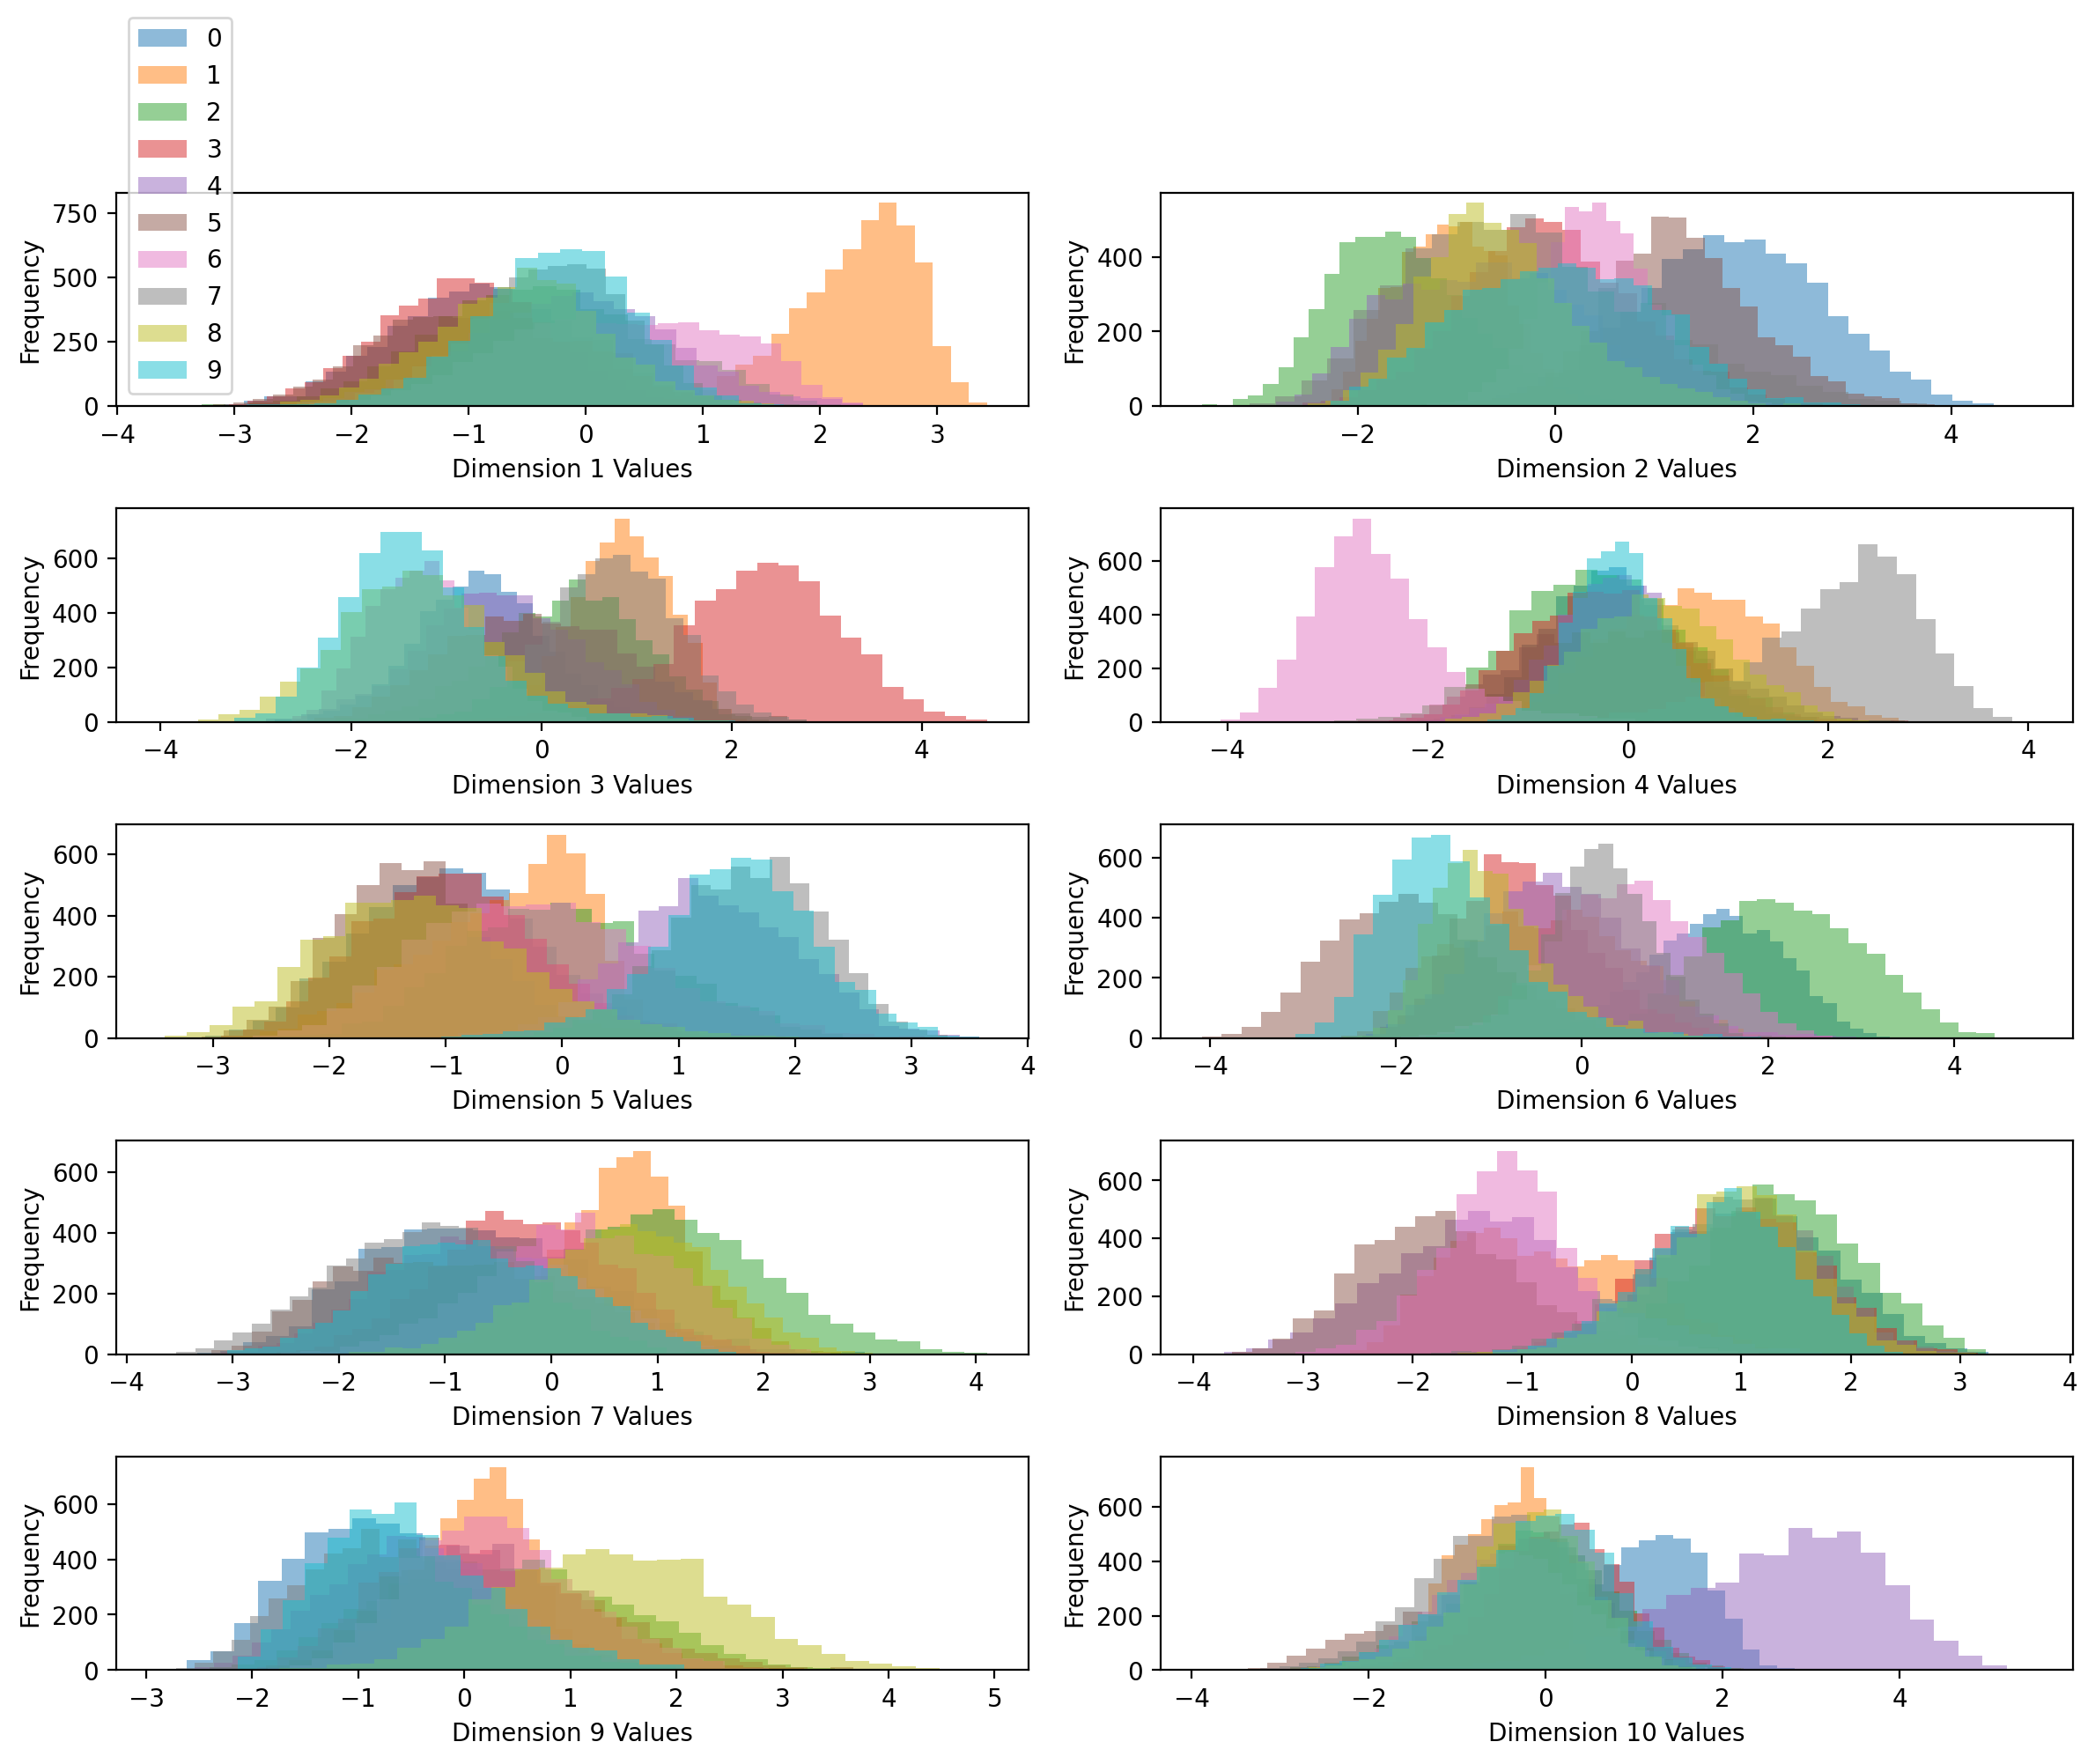

In [99]:
# Create histograms
num_classes=10
z_batches, y_batches = get_latent(VAE, unlabelled_train_data,latent_dims=latent_dims) 


fig, axes = plt.subplots(5, 2, figsize=(12, latent_dims))
axes = axes.flatten()  # Flatten the 2D array of axes to make indexing easier

for dim in range(latent_dims):
    ax = axes[dim]
    # Plot a histogram for each class
    for class_id in range(num_classes):
        # Select the data for the current class and dimension
        mask = y_batches == class_id
        ax.hist(z_batches[mask, dim], bins=30, alpha=0.5, label=f'{class_id}')

    
    # ax.set_title(f'Distribution of Dimension {dim+1} by Class')
    ax.set_xlabel(f'Dimension {dim+1} Values')
    ax.set_ylabel('Frequency')
    if dim == 0:
        ax.legend()

plt.tight_layout()
plt.show()

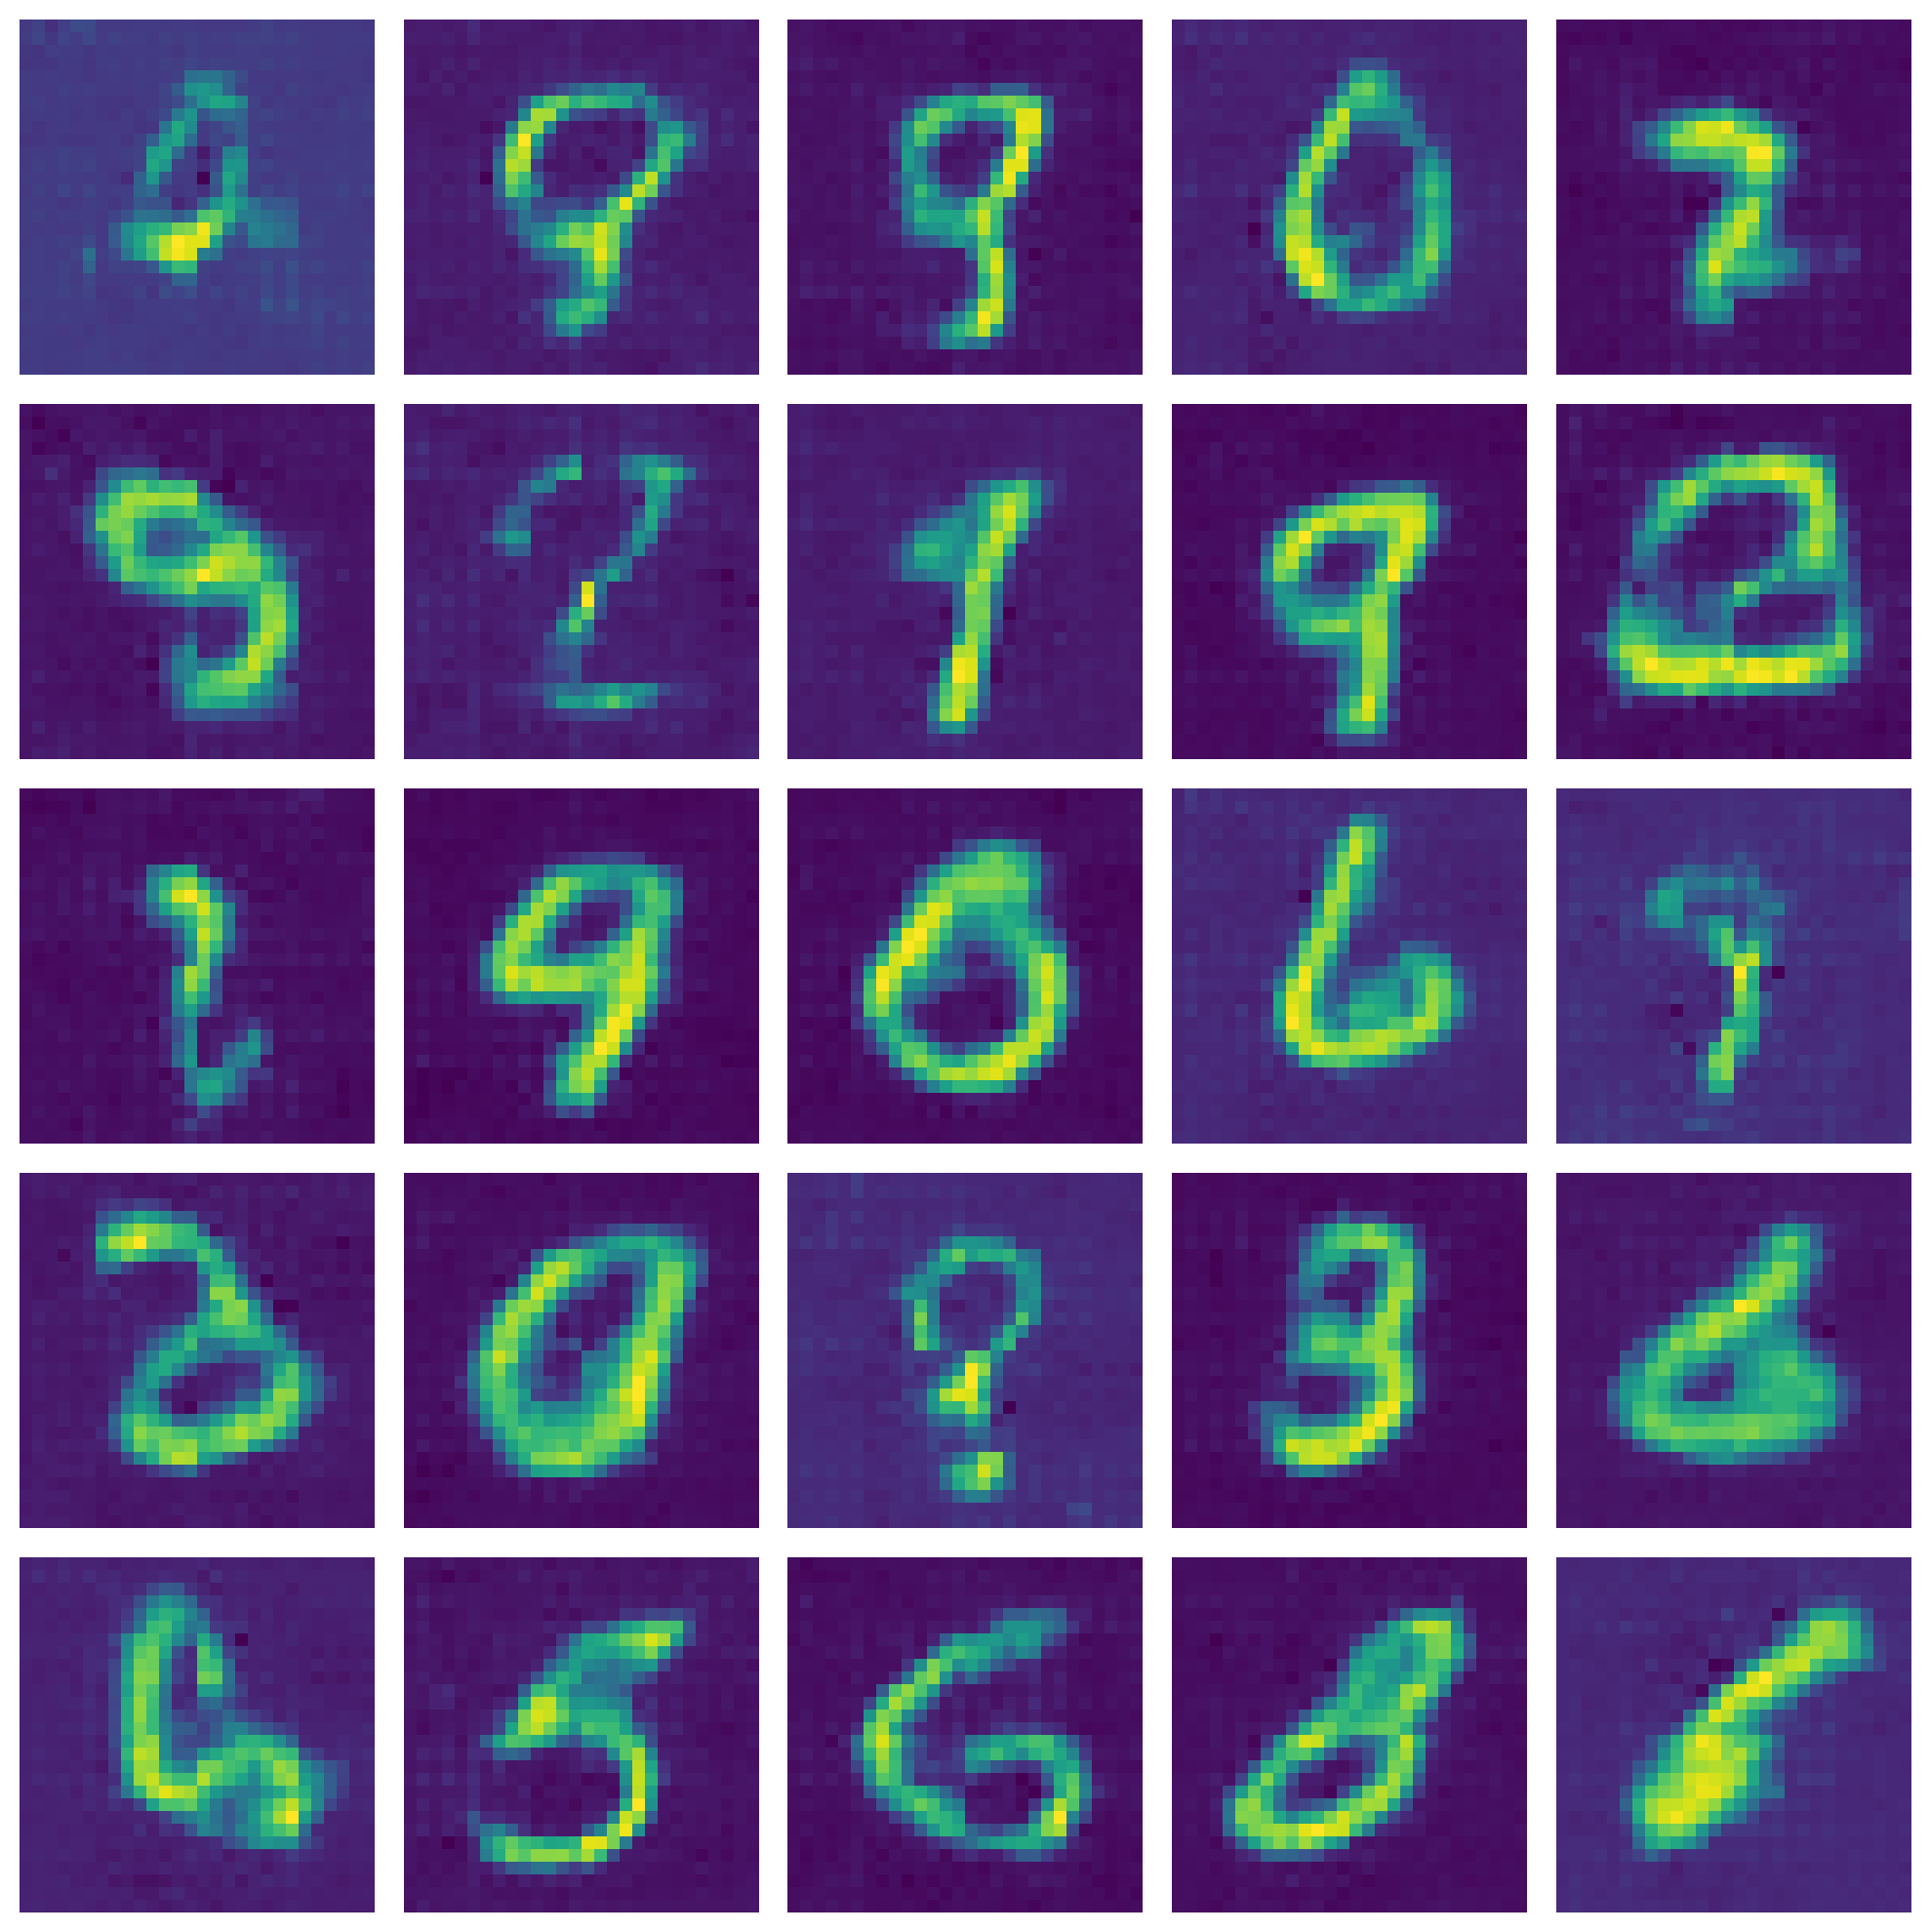

In [104]:
def sample_random(vae, n=10):
    # Create a figure with subplots in a grid of size ceil(sqrt(n)) by ceil(sqrt(n))
    rows = cols = int(n**0.5)
    if rows * cols < n:
        cols += 1
        
    fig, axes = plt.subplots(rows, cols, figsize=(cols*2, rows*2))
    axes = axes.flatten()
    
    for i in range(n):
        random_z = torch.randn(10)
        
        # Decode z to distribution parameters
        x_hat= vae.decoder(random_z.to('cuda'))
        
        # Show image
        ax = axes[i]
        im = x_hat.reshape(1, 28, 28).to('cpu').detach().numpy()
        ax.imshow(np.moveaxis(im,0,2))
        ax.axis('off')  # Hide axes
        
    # Hide unused axes
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')
    
    plt.tight_layout()
    plt.show()
sample_random(VAE, n=25)

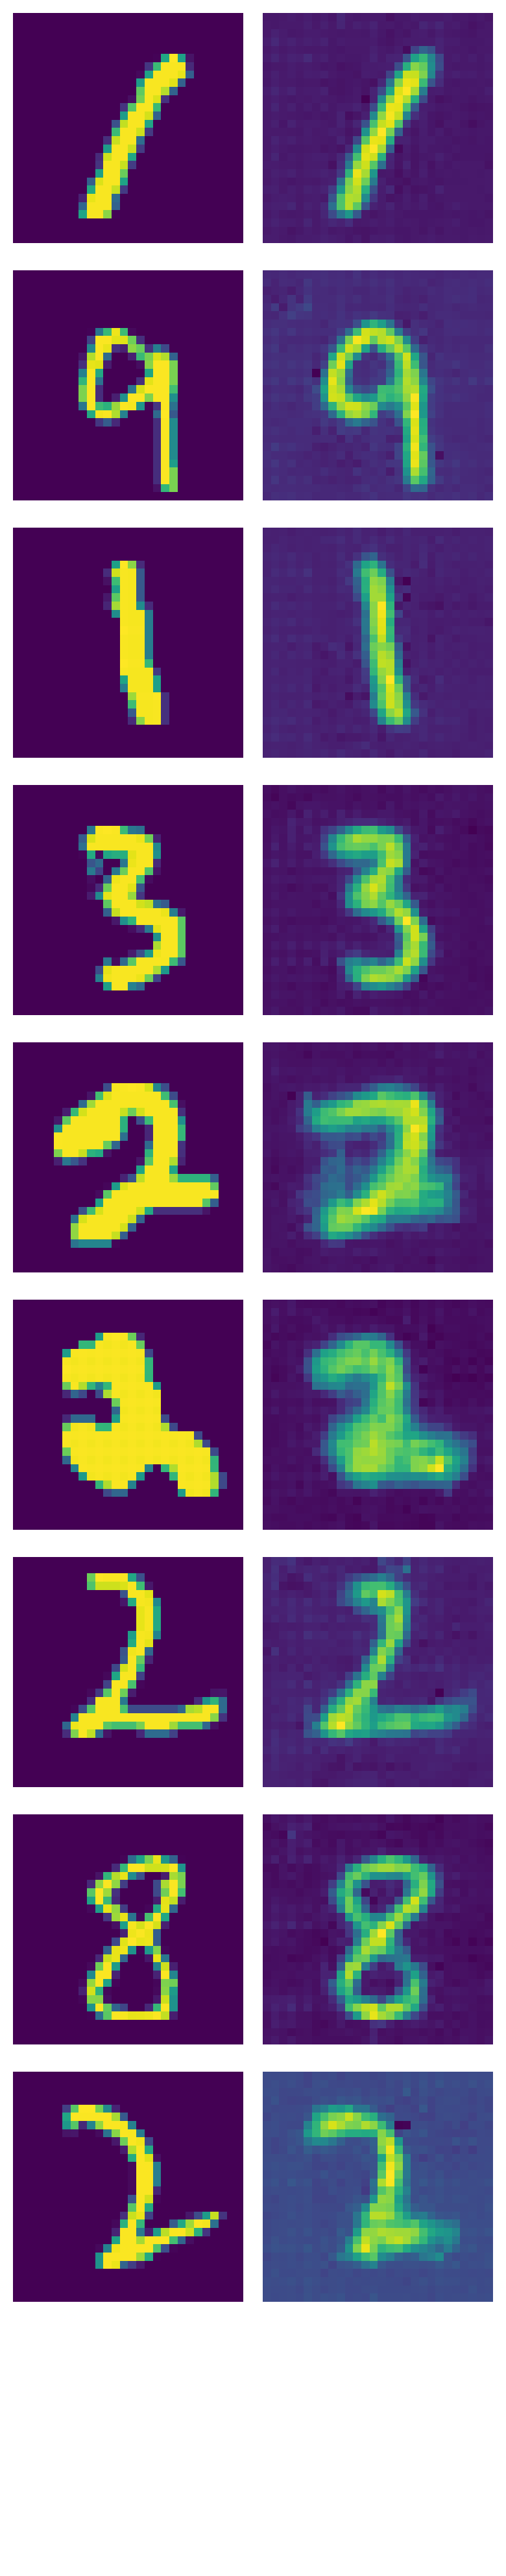

In [103]:
def reconstruct(vae, data, n=10):
    cols = 2
    rows = n
        
    fig, axes = plt.subplots(rows, cols, figsize=(cols*2, rows*2))
    axes = axes.flatten()
    
    # data loader with batch size 128
    for i, (x, y) in enumerate(data):
        # Decode z to distribution parameter
        
        x_hat, y_pred = vae(x.to('cuda'))
        # Show image
        ax = axes[2*i]
        im = x[0,:,:,:].reshape(1, 28, 28).to('cpu').detach().numpy()
        ax.imshow(np.moveaxis(im,0,2))
        ax.axis('off')  # Hide axes
        
        ax = axes[2*i+1]
        im = x_hat[0,:,:,:].reshape(1, 28, 28).to('cpu').detach().numpy()
        ax.imshow(np.moveaxis(im,0,2))
        ax.axis('off')  # Hide axes
        
        if i >= n - 1:
            break
    # Hide unused axes
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')
    
    plt.tight_layout()
    plt.show()
reconstruct(VAE,unlabelled_train_data)

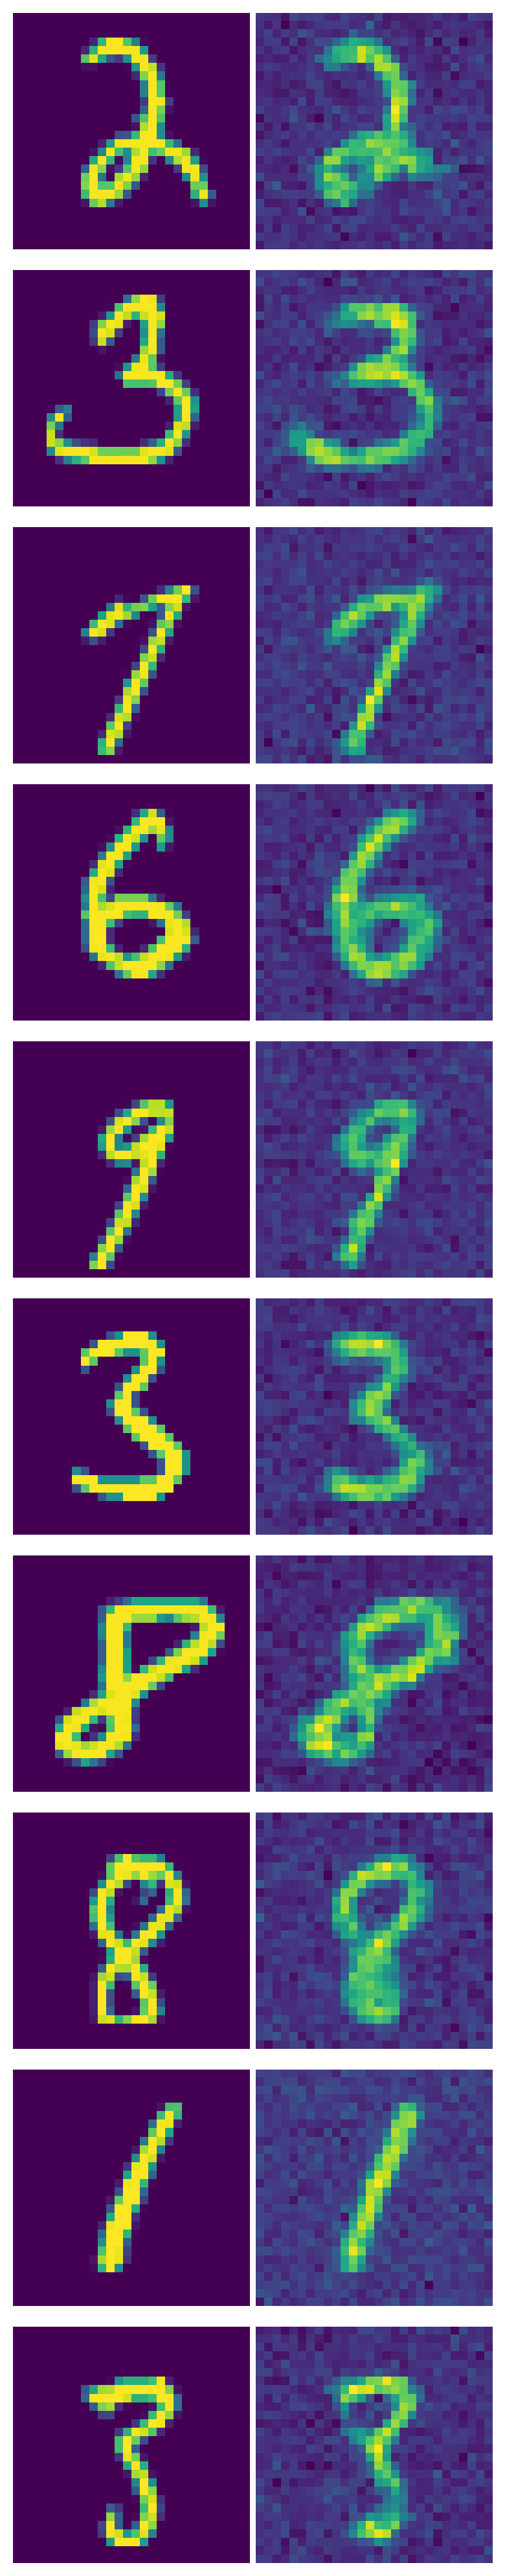

In [12]:
def reconstruct(vae, data, n=10):
    cols = 2
    rows = n
        
    fig, axes = plt.subplots(rows, cols, figsize=(cols*2, rows*2))
    axes = axes.flatten()
    
    # data loader with batch size 128
    for i, (x, y) in enumerate(data):
        # Decode z to distribution parameter
        
        x_hat, y_pred = vae(x.to('cuda'))
        # Show image
        ax = axes[2*i]
        im = x[0,:,:,:].reshape(1, 28, 28).to('cpu').detach().numpy()
        ax.imshow(np.moveaxis(im,0,2))
        ax.axis('off')  # Hide axes
        
        ax = axes[2*i+1]
        im = x_hat[0,:,:,:].reshape(1, 28, 28).to('cpu').detach().numpy()
        ax.imshow(np.moveaxis(im,0,2))
        ax.axis('off')  # Hide axes
        
        if i >= n - 1:
            break
    # Hide unused axes
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')
    
    plt.tight_layout()
    plt.show()
reconstruct(VAE,unlabelled_train_data)

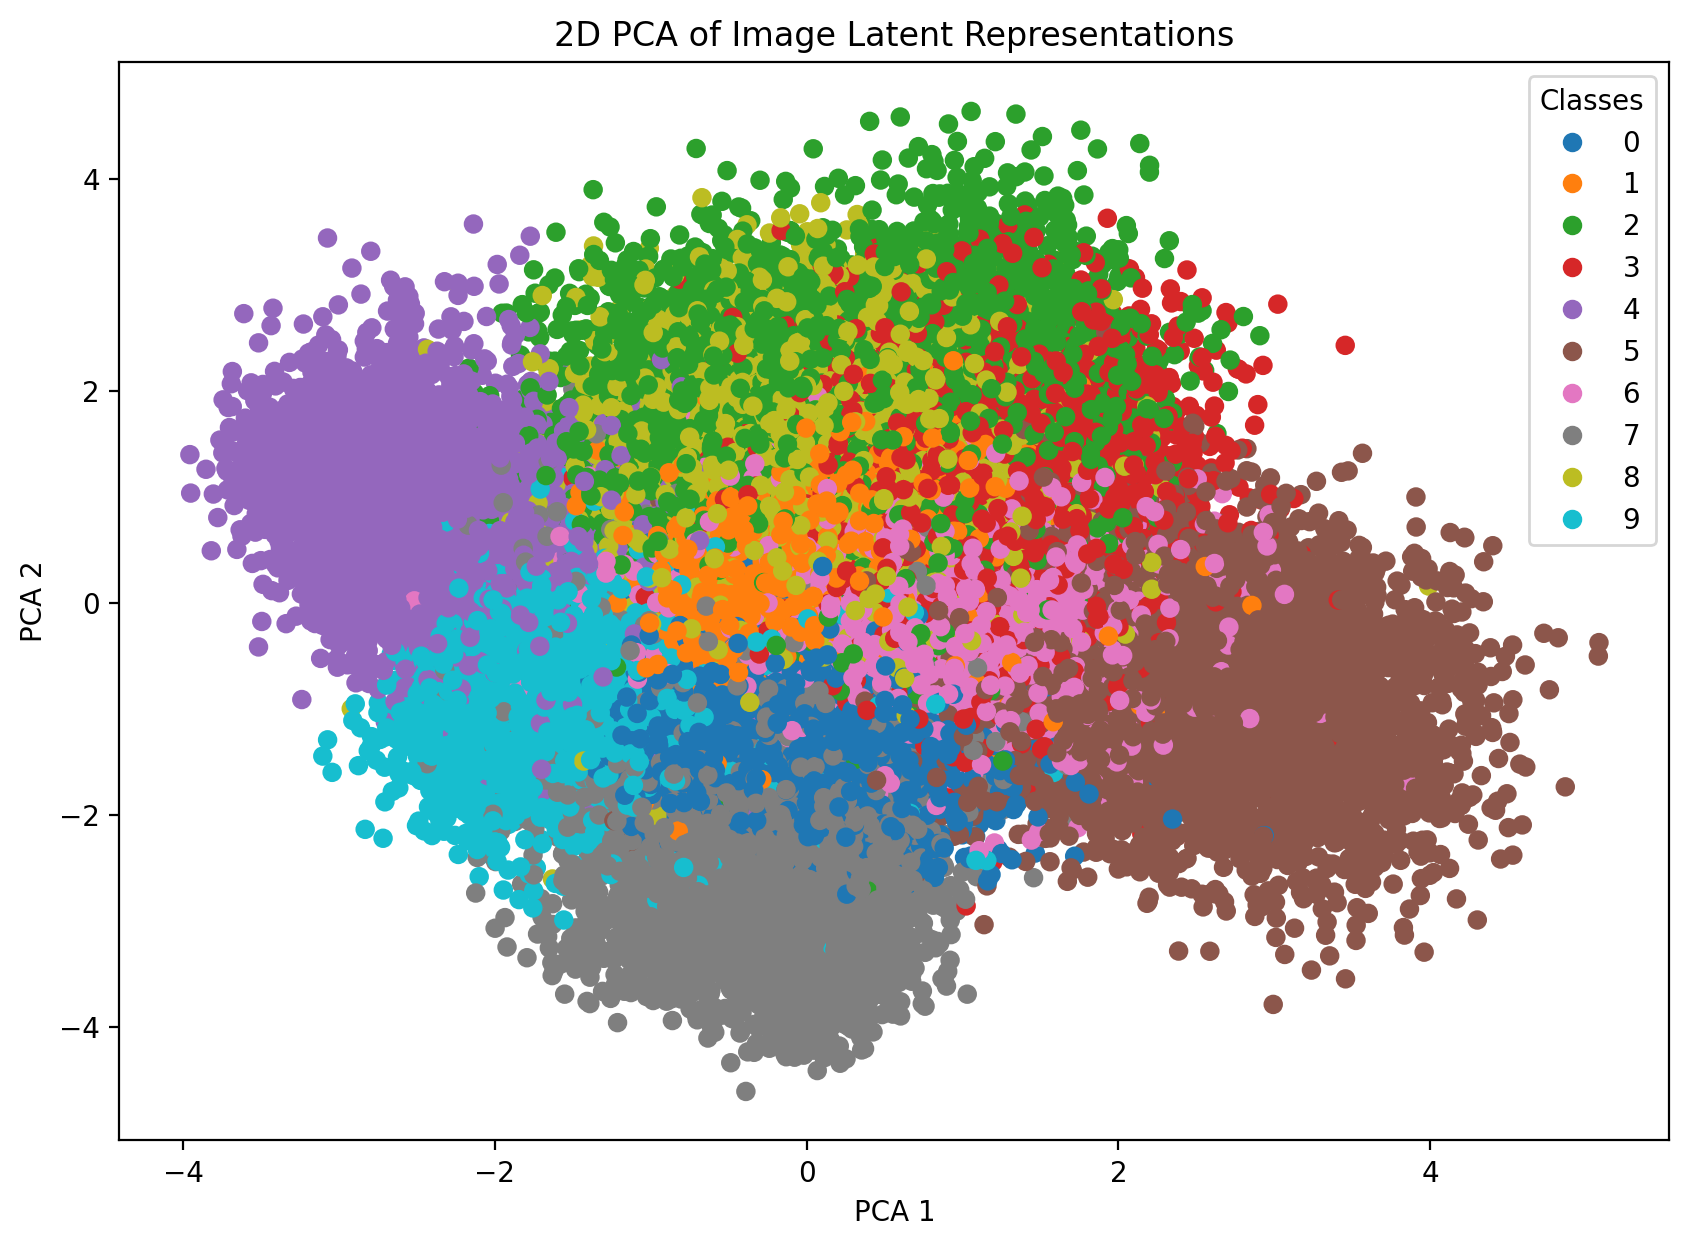

In [162]:
def get_latent(vae, data, num_batches=100, latent_dims=20):
    z_batches = torch.empty((0, latent_dims))
    y_batches = torch.empty((0, ))
    
    # data loader with batch size 128
    for i, (x, y) in enumerate(data):
        # Decode z to distribution parameters
        mu, sigma = vae.encoder(x.to('cuda'))

        z = mu + sigma*vae.encoder.N.sample(mu.shape)
        z = z.to('cpu').detach()
        
        z_batches = torch.cat((z_batches, z), dim=0)
        y_batches = torch.cat((y_batches, y), dim=0)
        
        if i >= num_batches - 1:
            break

    return z_batches, y_batches

# get some latent reprs of several batches
z_batches, y_batches = get_latent(VAE, unlabelled_train_data,latent_dims=latent_dims) 

from sklearn.decomposition import PCA

latent_representations = z_batches.numpy()
classes = y_batches.numpy()

# Apply PCA to reduce to 2 dimensions
pca = PCA(n_components=2)
latent_2d = pca.fit_transform(latent_representations)

# Plotting
plt.figure(figsize=(10, 7))
scatter = plt.scatter(latent_2d[:, 0], latent_2d[:, 1], c=classes, cmap='tab10')
plt.title('2D PCA of Image Latent Representations')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')

plt.legend(*scatter.legend_elements(),
                    loc="best", title="Classes")


plt.show()

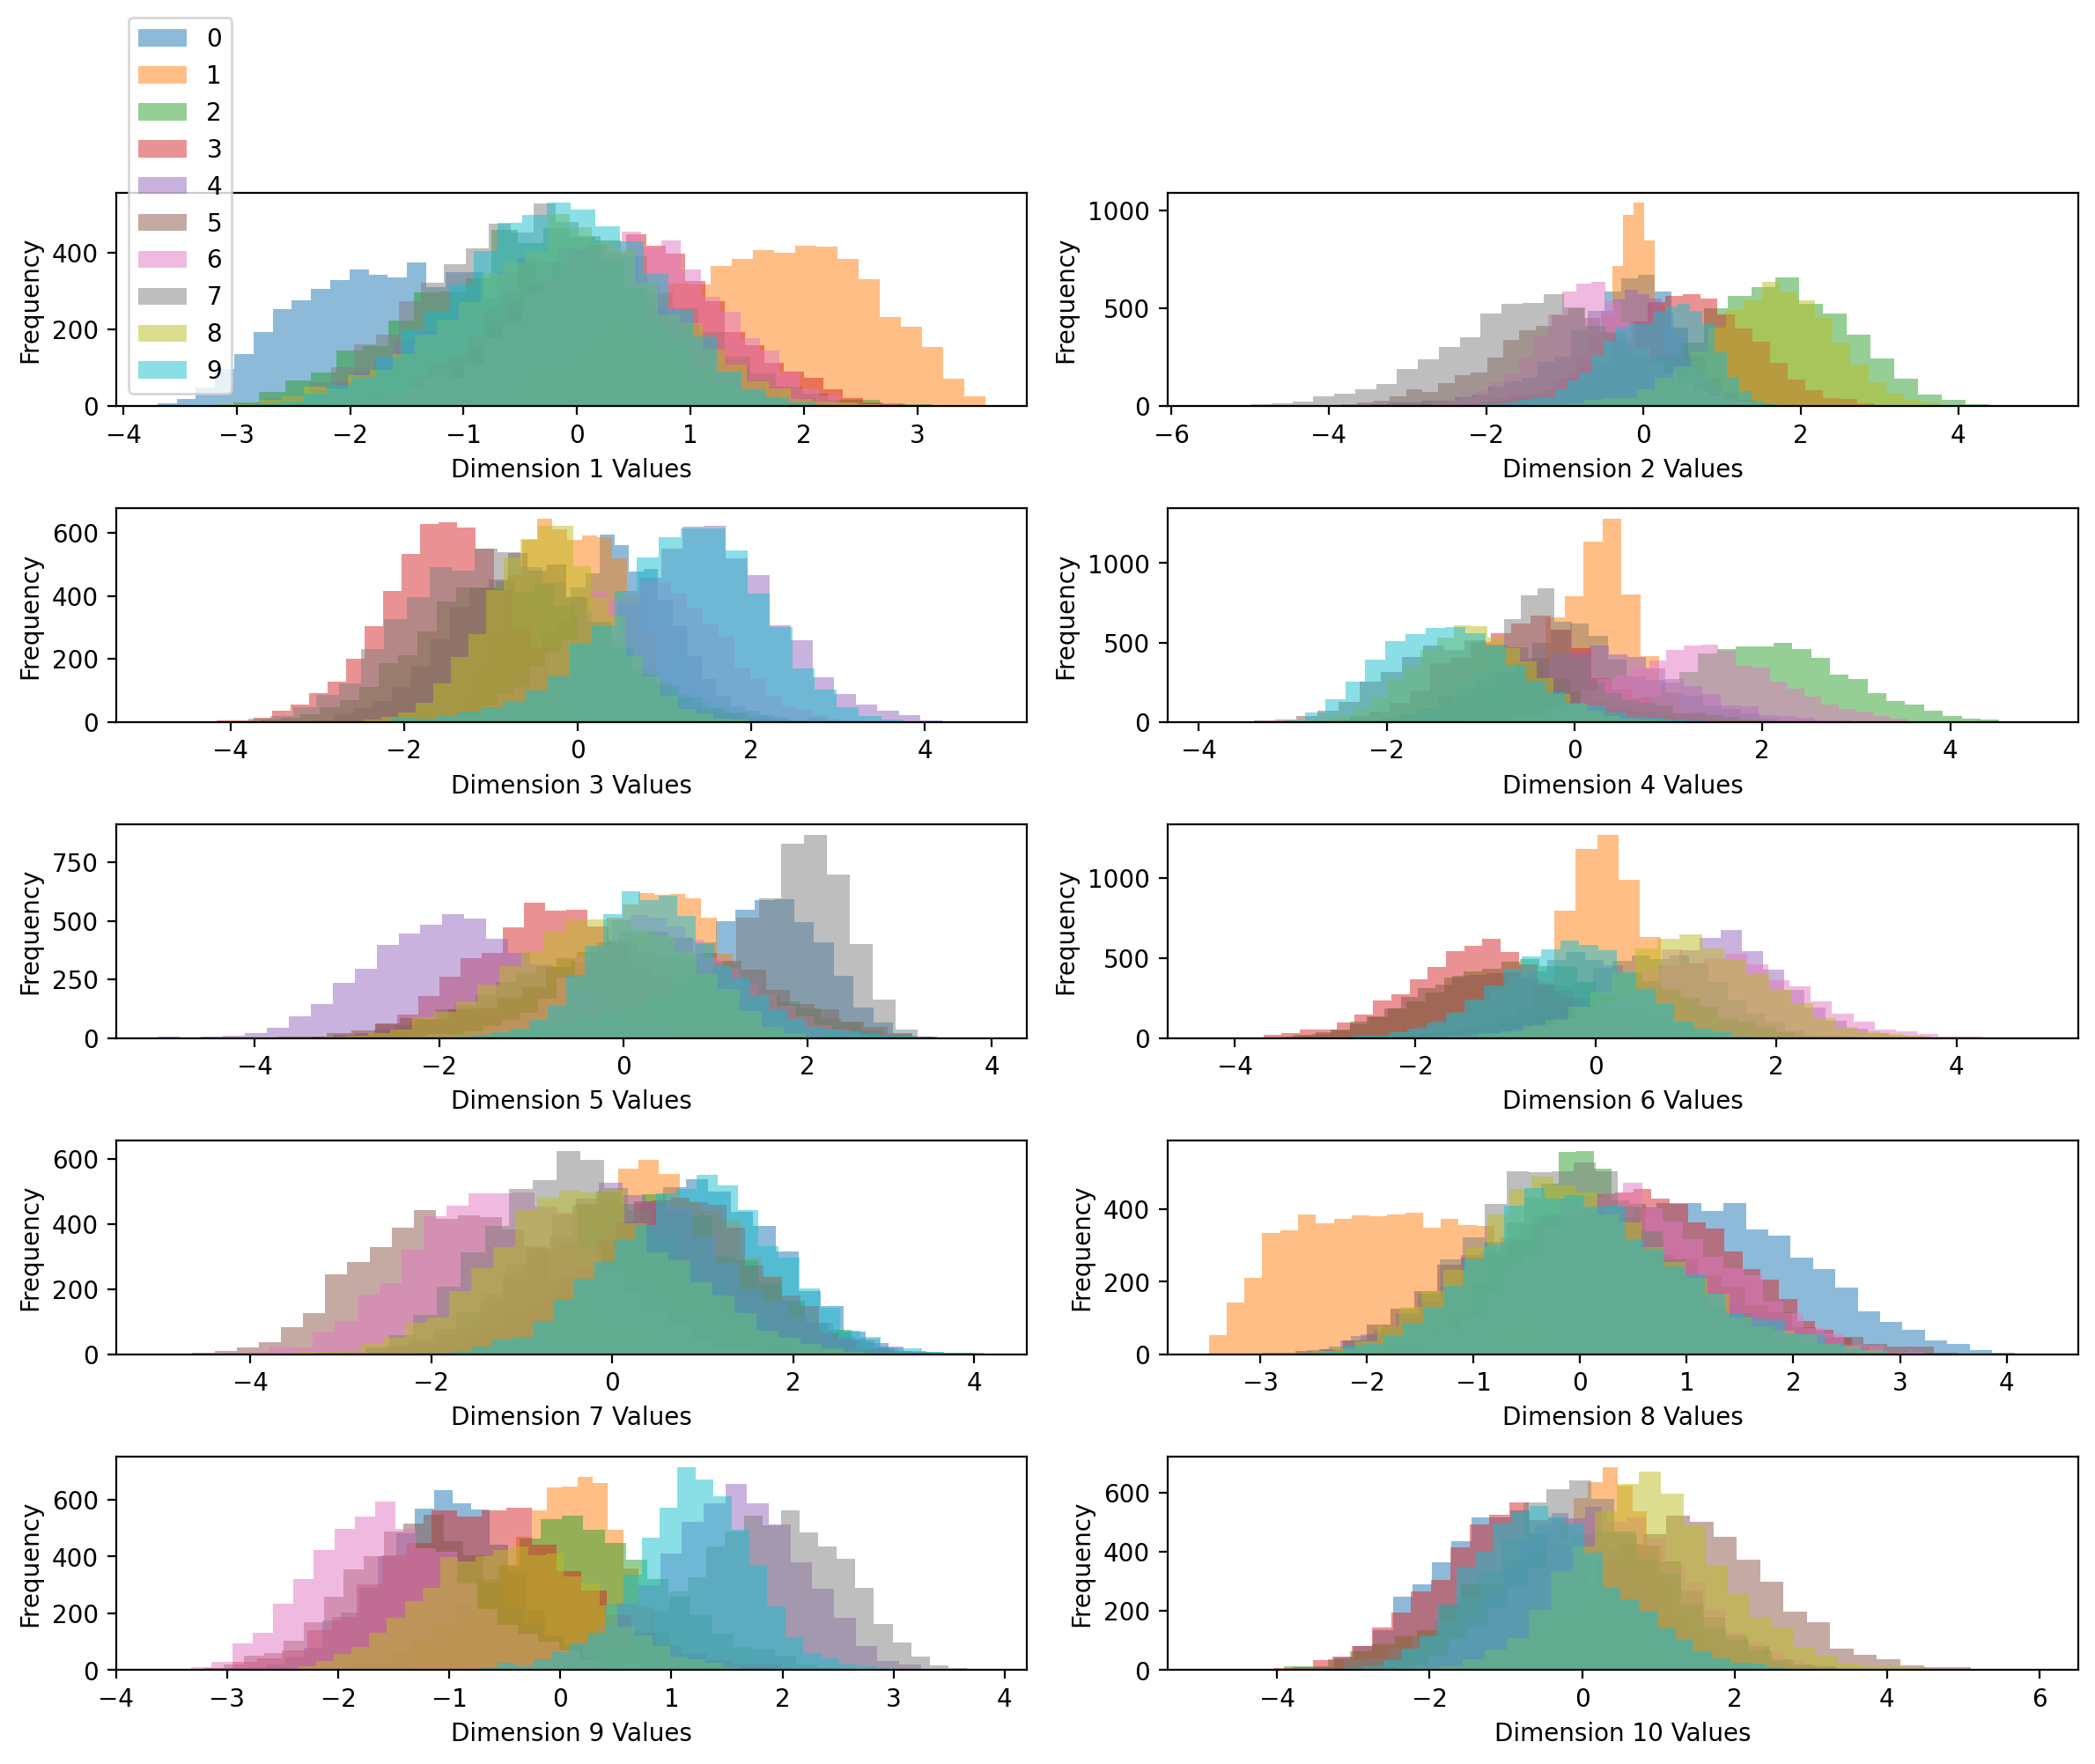

In [163]:
# Create histograms
num_classes=10
z_batches, y_batches = get_latent(VAE, unlabelled_train_data,latent_dims=latent_dims) 


fig, axes = plt.subplots(5, 2, figsize=(12, latent_dims))
axes = axes.flatten()  # Flatten the 2D array of axes to make indexing easier

for dim in range(latent_dims):
    ax = axes[dim]
    # Plot a histogram for each class
    for class_id in range(num_classes):
        # Select the data for the current class and dimension
        mask = y_batches == class_id
        ax.hist(z_batches[mask, dim], bins=30, alpha=0.5, label=f'{class_id}')

    
    # ax.set_title(f'Distribution of Dimension {dim+1} by Class')
    ax.set_xlabel(f'Dimension {dim+1} Values')
    ax.set_ylabel('Frequency')
    if dim == 0:
        ax.legend()

plt.tight_layout()
plt.show()

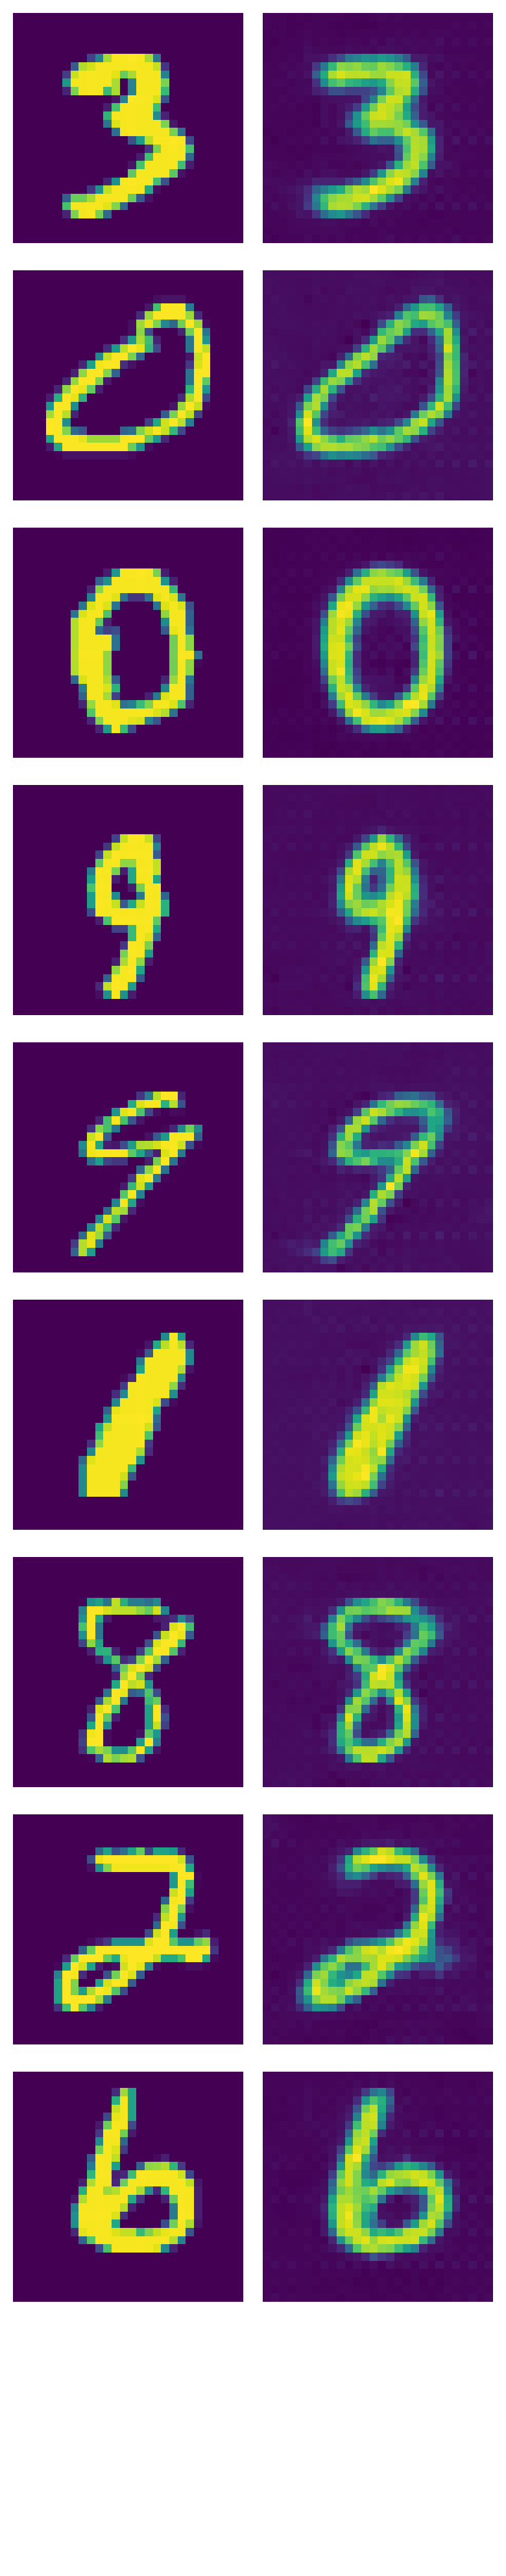

In [164]:
def reconstruct(vae, data, n=10):
    cols = 2
    rows = n
        
    fig, axes = plt.subplots(rows, cols, figsize=(cols*2, rows*2))
    axes = axes.flatten()
    
    # data loader with batch size 128
    for i, (x, y) in enumerate(data):
        # Decode z to distribution parameter
        
        x_hat, y_pred = vae(x.to('cuda'))
        # Show image
        ax = axes[2*i]
        im = x[0,:,:,:].reshape(1, 28, 28).to('cpu').detach().numpy()
        ax.imshow(np.moveaxis(im,0,2))
        ax.axis('off')  # Hide axes
        
        ax = axes[2*i+1]
        im = x_hat[0,:,:,:].reshape(1, 28, 28).to('cpu').detach().numpy()
        ax.imshow(np.moveaxis(im,0,2))
        ax.axis('off')  # Hide axes
        
        if i >= n - 1:
            break
    # Hide unused axes
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')
    
    plt.tight_layout()
    plt.show()
reconstruct(VAE,unlabelled_train_data)

In [ ]:
from VAE_Latent import VAEClassifer
from training_latent import train

latent_dims = 10
VAE = VAEClassifer(latent_dims,classes=10).to(device) # GPU
VAE = train(VAE, unlabelled_train_data, labelled_train_data, valid_data,epochs=20000, loss_weights={"consistency": 1, "classifer": 2, "aggregate": 80} ,sav_file="mnist_model_100labels_latent.sav")

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 14360/20000 [7:37:14<274:20:38, 175.11s/it]